In [1]:
# import bibs
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

**In your project, the following work steps will overlap and combine:**
- Feature selection
- Sampling 
- Feature engineering

**1. Selection of features:**

You must select the right features (columns) that have the greatest impact on the main outcome of the project (**sales of tools for the metal industry**). There should be a causal relationship between the features and sales.

<u>Your task will be to select features from the following areas:<u>
- Employment
- Establishment
- Payroll 
- Economic strength 


**2. Filtering:** 

Identify the most important occupations and industries that have a **realistically high tool consumption**

**3. Feature engineering / construction / aggregation:**

In all three datasets there are duplicates in the FIPS column as further dimensions are mapped in the naics or occ_code columns. This makes specific combinations of FIPS, NAICS, Occupation and a specific feature in a row possible. <br>

Due to the requirement to use a **cluster algorithm**, the final dataframe must have a special form. **Each region (FIPS number) may only occur once in the df.** 
You must therefore prioritize the industries and occupations in this step and create special features that contain the Occupation or Industry dimension within them.

This is called **Pivoting or Wide-Format-Transformation**

<u>Possible features could be as listed below:<u>

- Number of employees in foundries (NAICS: 3315)
- Number of grinders (OCC: 51-9022)
- Number of grinders (OCC: 51-9022) in foundries (NAICS: 3315)

# Loading data

In [2]:
current_folder = os.getcwd()
project_folder = os.path.abspath(os.path.join(current_folder, '..', '..'))
data_path = project_folder + "/data/raw/"

In [3]:
df_pattern = pd.read_pickle(data_path +"naics_pattern.pickle")

In [4]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
unique_lengths = df_pattern['FIPS'].apply(len).unique()
unique_lengths

array([4, 5], dtype=int64)

In [5]:
def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

In [6]:
df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

# Feature overview

In [7]:
df_pattern.columns

Index(['State_GEOID', 'County_GEOID', 'FIPS', 'naics_2', 'naics',
       'DESCRIPTION', 'emp_nf', 'emp', 'qp1_nf', 'qp1', 'ap_nf', 'ap', 'est',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4'],
      dtype='object')

**Features:**

- **emp:** employment + noise flag
- **qp1:** first quarter payroll + noise flag
- **ap:** anual payroll + noise flag
- **est:** number of establishments (total and for different employment sizes)

# Feature selection 

We will select an exemplary feature in this code.<br>  

We will focus on the feature **number of companies (est)**. Regions where specific industries are located or concentrated will usually also consume tools.

In [8]:
df_pattern.head(3)

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,N


In [9]:
result = df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    est_sum=('est', 'sum'),             # Summe der Werte in der Spalte 'Wert'
    unique_FIPS=('FIPS', 'nunique')  # Anzahl eindeutiger Werte in der Spalte 'Kategorie'
).sort_values(by='est_sum', ascending=False)
result.head(40)

,,est_sum,unique_FIPS
naics,DESCRIPTION,,
5617,Services to Buildings and Dwellings,220492,2530
2382,Building Equipment Contractors,193562,2756
8111,Automotive Repair and Maintenance,164584,2725
2383,Building Finishing Contractors,124074,2040
5413,"Architectural, Engineering, and Related Services",115269,1924
2381,"Foundation, Structure, and Building Exterior Contractors",101383,2313
7139,Other Amusement and Recreation Industries,76488,2182
4413,"Automotive Parts, Accessories, and Tire Stores",58112,2427
5613,Employment Services,57057,1306


What is NAICS 3320A2 ? -- 3323, 3323

https://www.bls.gov/oes/2023/may/naics4_3320A2.htm

Fabricated Metal Product Manufacturing (3323 and 3324 only)

- 3323: Architectural and Structural Metals Manufacturing
- 3324: Boiler, Tank, and Shipping Container Manufacturing

# Feature construction

**How do you choose the most important and relevant industries?**

Viewed as a whole, the project has requirements from various sides:
- Domain: tool consumption / employment
- Modeling: clustering

<br> For the **domain side**, it makes sense to choose industries that have a high share of employment and a high consumption of tools.
<br> For the **modeling side**, it makes sense to cover as many regions as possible. Since we will later use a maximum of 15 features, it makes no sense to select industries that only occur in a very small number of regions. 

## Domain

### Tool consumption

Here, the individual industries must be evaluated by **domain knowledge** with regard to their potential tool consumption.<br>
We have ranked the industries before from 0-3 and averaged the rankings of the three team members.

In [10]:
# Read rankings and create dict from them
rankings_raw = pd.read_excel(data_path + "ranking_industries.xlsx")
rankings = rankings_raw.set_index('naics')['industry_score'].to_dict()
# rankings = {k:round(v,2) for k, v in rankings.items() if v >= 0.5}
rankings

{1133: 1.33,
 2111: 0.33,
 2121: 0.33,
 2122: 0.33,
 2123: 0.33,
 2131: 0.67,
 2211: 0.0,
 2212: 0.0,
 2362: 2.0,
 2371: 1.33,
 2373: 2.67,
 2379: 2.0,
 2381: 1.67,
 2382: 1.67,
 2383: 1.0,
 3119: 0.0,
 3132: 0.0,
 3211: 1.0,
 3212: 0.33,
 3219: 2.0,
 3222: 0.33,
 3231: 0.0,
 3241: 0.33,
 3261: 1.0,
 3262: 0.0,
 3311: 2.0,
 3312: 2.67,
 3313: 1.33,
 3314: 2.0,
 3315: 1.0,
 3327: 2.0,
 3328: 1.0,
 3333: 1.33,
 3335: 2.67,
 3336: 1.67,
 3344: 0.0,
 3345: 0.67,
 3361: 1.67,
 3362: 1.33,
 3363: 1.67,
 3364: 3.0,
 3365: 1.33,
 3366: 1.67,
 3391: 0.67,
 3399: 2.0,
 4231: 0.0,
 4238: 1.0,
 4411: 0.0,
 4412: 0.0,
 4413: 0.33,
 4811: 0.0,
 4812: 0.0,
 4861: 0.0,
 4862: 0.0,
 4881: 0.67,
 4882: 1.0,
 5321: 0.0,
 5413: 0.0,
 5612: 0.33,
 5613: 0.0,
 5617: 1.0,
 7139: 0.0,
 8111: 2.33,
 8113: 2.0,
 '3250A1': 0.0,
 '3320A1': 2.67,
 '3320A2': 3.0,
 '3330A1': 2.33,
 '3370A1': 1.67}

In [11]:
# Assign rankings to each entry
df_pattern['tool_consumption'] = df_pattern['naics'].map(rankings)
df_pattern['tool_consumption'] = df_pattern['tool_consumption'].apply(lambda x: round(x,2))
df_pattern.head(3)

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4,tool_consumption
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,NaN
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,NaN
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,NaN


In [12]:
# Remove industries where tool consumption is smaller than 0.5
df_pattern = df_pattern[df_pattern['tool_consumption'] >= 0.5].reset_index()
df_pattern

,index,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,...,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4,tool_consumption
0,79,01,003,01003,33,3320A2,"3323, 3323",G,122,G,...,N,N,N,N,N,N,N,N,N,3.00
1,81,01,003,01003,33,3320A1,"3321, 3322, 3325, 3326, 3329",J,72,J,...,N,N,N,N,N,N,N,N,N,2.67
2,82,01,003,01003,33,3330A1,"3331, 3332, 3334, 3339",J,247,H,...,N,N,N,N,N,N,N,N,N,2.33
3,85,01,003,01003,33,3370A1,"3371, 3372",G,194,G,...,N,N,N,N,N,N,N,N,N,1.67
4,260,01,009,01009,33,3320A2,"3323, 3323",G,95,G,...,N,N,N,N,N,N,N,N,N,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463,187968,56,025,56025,33,3370A1,"3371, 3372",G,22,H,...,N,N,N,N,N,N,N,N,N,1.67
4464,188088,56,029,56029,33,3320A1,"3321, 3322, 3325, 3326, 3329",J,14,G,...,N,N,N,N,N,N,N,N,N,2.67
4465,188188,56,033,56033,33,3320A2,"3323, 3323",J,32,J,...,N,N,N,N,N,N,N,N,N,3.00
4466,188391,56,039,56039,33,3320A2,"3323, 3323",J,10,H,...,N,N,N,N,N,N,N,N,N,3.00


### Share of Employment

In [13]:
df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    emp_sum=('emp', 'sum')             # Sum of values in the 'emp' column
      ).sort_values(by='emp_sum', ascending=False)

,,emp_sum
naics,DESCRIPTION,
3330A1,"3331, 3332, 3334, 3339",488895
3320A2,"3323, 3323",343891
3320A1,"3321, 3322, 3325, 3326, 3329",315026
3370A1,"3371, 3372",257375


## Modeling 

### Unique FIPS

In [14]:
df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    unique_FIPS=('FIPS', 'nunique')            # Count of unique values in the 'FIPS' column
      # Count of unique values in the 'category' column
).sort_values(by='unique_FIPS', ascending=False)

,,unique_FIPS
naics,DESCRIPTION,
3320A2,"3323, 3323",1057
3370A1,"3371, 3372",861
3330A1,"3331, 3332, 3334, 3339",699
3320A1,"3321, 3322, 3325, 3326, 3329",592


## Ranking

In [15]:
result = df_pattern.groupby(['naics', 'DESCRIPTION', 'tool_consumption']).agg(
    emp_sum=('emp', 'sum'), # Sum of values in the 'emp' column
    est_sum=('est', 'sum'), # Sum of values in the 'est' column
    unique_FIPS=('FIPS', 'nunique')    # Count of unique values in the 'FIPS' column
).sort_values(by='emp_sum', ascending=False).reset_index()

# Display the first 40 rows
result

,naics,DESCRIPTION,tool_consumption,emp_sum,est_sum,unique_FIPS
0,3330A1,"3331, 3332, 3334, 3339",2.33,488895,9525,699
1,3320A2,"3323, 3323",3.00,343891,12558,1057
2,3320A1,"3321, 3322, 3325, 3326, 3329",2.67,315026,7798,592
3,3370A1,"3371, 3372",1.67,257375,11709,861


In [16]:
# Create a copy of the DataFrame
result_copy = result.copy()

# Calculate rank for all columns starting from 'tool_consumption', with equal values having the same rank
for column in result_copy.columns[result_copy.columns.get_loc('tool_consumption'):]:
    rank_column_name = f'rank_{column}'
    result_copy[rank_column_name] = result_copy[column].rank(method='min', ascending=False).astype(int)

# Display the first few rows of the copied data
result_copy.head()

,naics,DESCRIPTION,tool_consumption,emp_sum,est_sum,unique_FIPS,rank_tool_consumption,rank_emp_sum,rank_est_sum,rank_unique_FIPS
0,3330A1,"3331, 3332, 3334, 3339",2.33,488895,9525,699,3,1,3,3
1,3320A2,"3323, 3323",3.00,343891,12558,1057,1,2,1,1
2,3320A1,"3321, 3322, 3325, 3326, 3329",2.67,315026,7798,592,2,3,4,4
3,3370A1,"3371, 3372",1.67,257375,11709,861,4,4,2,2


In [17]:
weights = {
    'rank_tool_consumption': 0.5,   # Weight for the ranking column 'tool_consumption'
    'rank_emp_sum': 0.25,
    'rank_est_sum': 0.15, # Weight for the ranking column 'emp_sum'
    'rank_unique_FIPS': 0.1         # Weight for the ranking column 'unique_FIPS'
}

In [18]:
# calculate the weighted sum
result_copy['Weighted_Sum'] = (result_copy['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          result_copy['rank_emp_sum'] * weights['rank_emp_sum'] +
                          result_copy['rank_unique_FIPS'] * weights['rank_unique_FIPS'])
result_sorted = result_copy.sort_values(by='Weighted_Sum', ascending=True)

In [19]:
result_sorted.head(10)

,naics,DESCRIPTION,tool_consumption,emp_sum,est_sum,unique_FIPS,rank_tool_consumption,rank_emp_sum,rank_est_sum,rank_unique_FIPS,Weighted_Sum
1,3320A2,"3323, 3323",3.00,343891,12558,1057,1,2,1,1,1.10
0,3330A1,"3331, 3332, 3334, 3339",2.33,488895,9525,699,3,1,3,3,2.05
2,3320A1,"3321, 3322, 3325, 3326, 3329",2.67,315026,7798,592,2,3,4,4,2.15
3,3370A1,"3371, 3372",1.67,257375,11709,861,4,4,2,2,3.20


In [20]:
# Set how many industries are selected
n_top_industries = 5
n_rest_industries = 10

In [21]:
# Set NAICS codes of desired industries
top_industries = result_sorted[:n_top_industries]['naics'].tolist()
rest_industries = result_sorted[n_top_industries+1:n_top_industries+n_rest_industries]['naics'].tolist()
display(top_industries)
display(rest_industries)

['3320A2', '3330A1', '3320A1', '3370A1']

[]

# feature_df

In [22]:
df_pattern.columns

Index(['index', 'State_GEOID', 'County_GEOID', 'FIPS', 'naics_2', 'naics',
       'DESCRIPTION', 'emp_nf', 'emp', 'qp1_nf', 'qp1', 'ap_nf', 'ap', 'est',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4',
       'tool_consumption'],
      dtype='object')

In [23]:
# Set column for features
feature_column = 'emp'
feature_column_name = 'Employees'

In [24]:
# Assume `df` is the original DataFrame

# Create a new DataFrame with unique FIPS values
feature_df_pattern = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

# Add a new column with the corresponding 'emp' values for the top 5 industries
for naics_code in top_industries:
    # Filter the rows for the current NAICS code and get the corresponding 'emp' values
    feature_column_values = df_pattern[df_pattern['naics'] == naics_code].set_index('FIPS')[feature_column]
    
    # Merge the 'est' values as a new column in the new DataFrame
    feature_df_pattern = feature_df_pattern.merge(feature_column_values, how='left', left_on='FIPS', right_index=True)
    
    # Rename the column based on the NAICS code
    feature_df_pattern = feature_df_pattern.rename(columns={feature_column: f'{feature_column}_{naics_code}'})

# Add new column with the corresponding aggregated 'emp' value for the top 6 to top 15 industries aggregated
rest_sums = df_pattern.loc[df_pattern['naics'].isin(rest_industries)].groupby('FIPS')[feature_column].sum() / n_rest_industries
feature_df_pattern = feature_df_pattern.merge(rest_sums, how='left', left_on='FIPS', right_index=True)
feature_df_pattern = feature_df_pattern.rename(columns={feature_column: f'{feature_column}_rest'})

# Set zero values to NaN
feature_df_pattern = feature_df_pattern.replace(0, np.nan)

# Display the result
feature_df_pattern

,FIPS,emp_3320A2,emp_3330A1,emp_3320A1,emp_3370A1,emp_rest
0,01003,122.0,247.0,72.0,194.0,NaN
1,01009,95.0,NaN,NaN,16.0,NaN
2,01015,326.0,NaN,752.0,33.0,NaN
3,01021,75.0,NaN,NaN,6.0,NaN
4,01027,NaN,NaN,NaN,1780.0,NaN
...,...,...,...,...,...,...
1385,56021,86.0,NaN,198.0,NaN,NaN
1386,56025,51.0,484.0,42.0,22.0,NaN
1387,56029,NaN,NaN,14.0,NaN,NaN
1388,56033,32.0,NaN,NaN,NaN,NaN


In [25]:
feature_df_pattern.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4873 entries, 0 to 1389
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FIPS        4873 non-null   object 
 1   emp_3320A2  4521 non-null   float64
 2   emp_3330A1  4116 non-null   float64
 3   emp_3320A1  3972 non-null   float64
 4   emp_3370A1  4282 non-null   float64
 5   emp_rest    0 non-null      float64
dtypes: float64(5), object(1)
memory usage: 266.5+ KB


# Scaling 

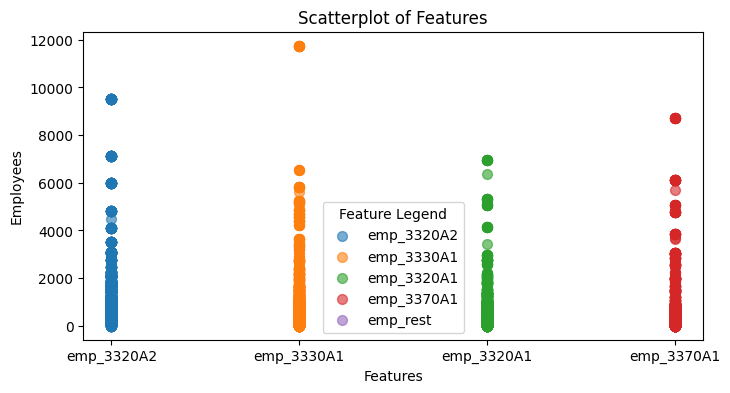

In [26]:
# Drop 'FIPS' column
feature_df_pattern_no_fips = feature_df_pattern.drop(columns='FIPS')

plt.figure(figsize=(8,4))

# Plot points without NaN values for each column except 'FIPS'
for col in feature_df_pattern_no_fips.columns:
    # Remove NaN values
    non_nan_data = feature_df_pattern_no_fips[col].dropna()
    plt.scatter([col] * len(non_nan_data), non_nan_data, s=50, alpha=0.6, label=col)  # Set s to a fixed value

plt.xlabel("Features")
plt.ylabel(feature_column_name)
plt.title("Scatterplot of Features")
plt.legend(title="Feature Legend")
plt.show()


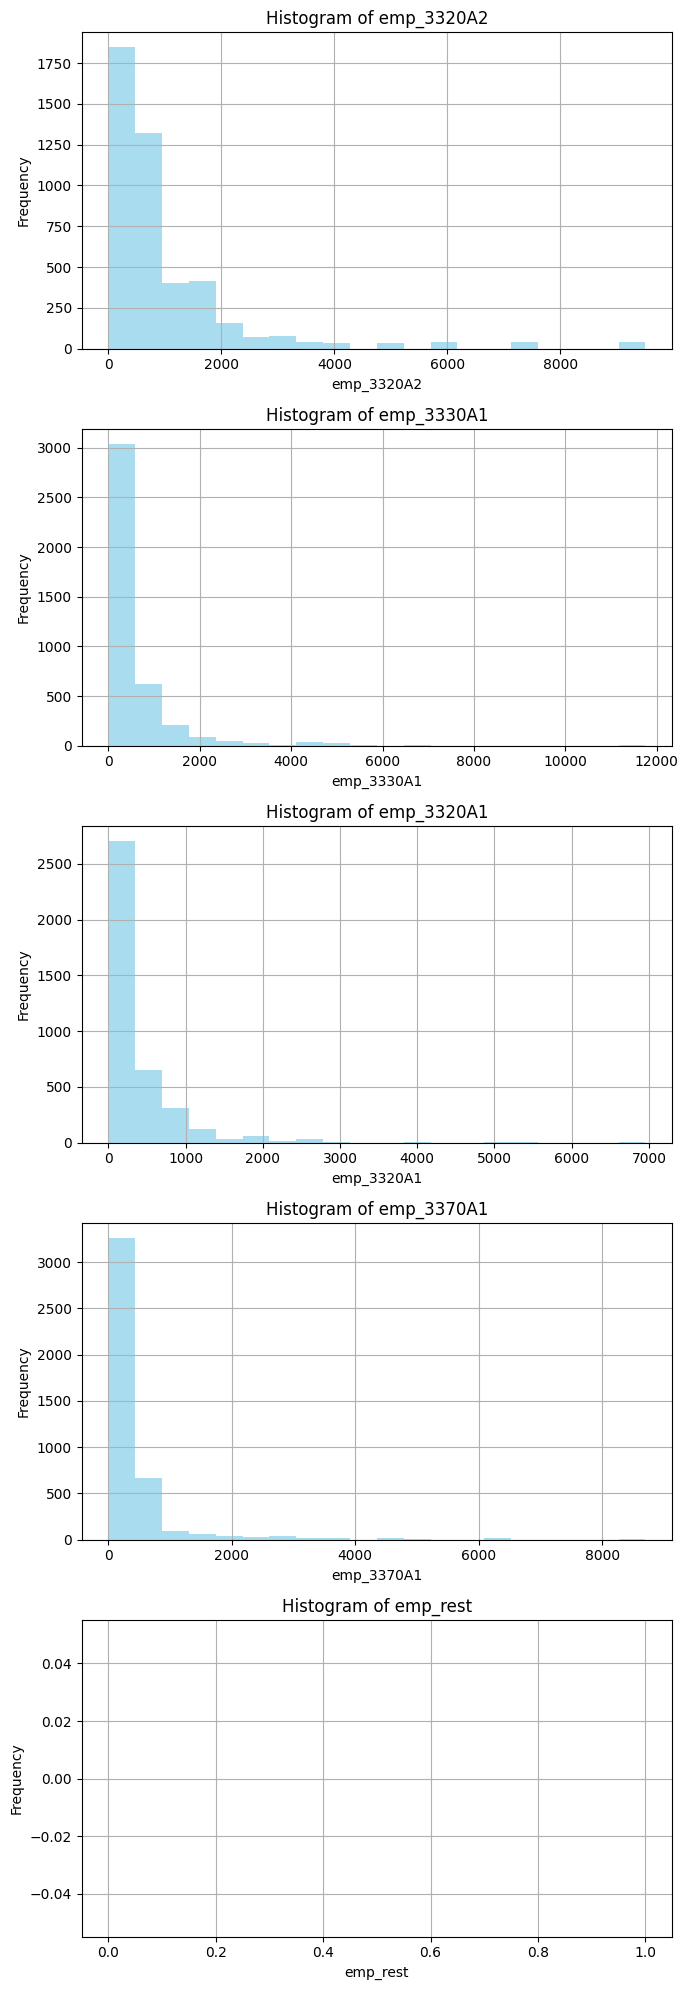

In [27]:
# Drop the 'FIPS' column
feature_df_pattern_no_fips = feature_df_pattern.drop(columns='FIPS')

# Number of columns (features)
n_features = len(feature_df_pattern_no_fips.columns)

# Set up subplots (one row and as many columns as there are features)
fig, axes = plt.subplots(n_features, 1, figsize=(7, 4 * n_features))

# Create a histogram for each feature
for i, col in enumerate(feature_df_pattern_no_fips.columns):
    axes[i].hist(feature_df_pattern_no_fips[col].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\sklearn\utils\_array_api.py:769: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\sklearn\utils\_array_api.py:786: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= 

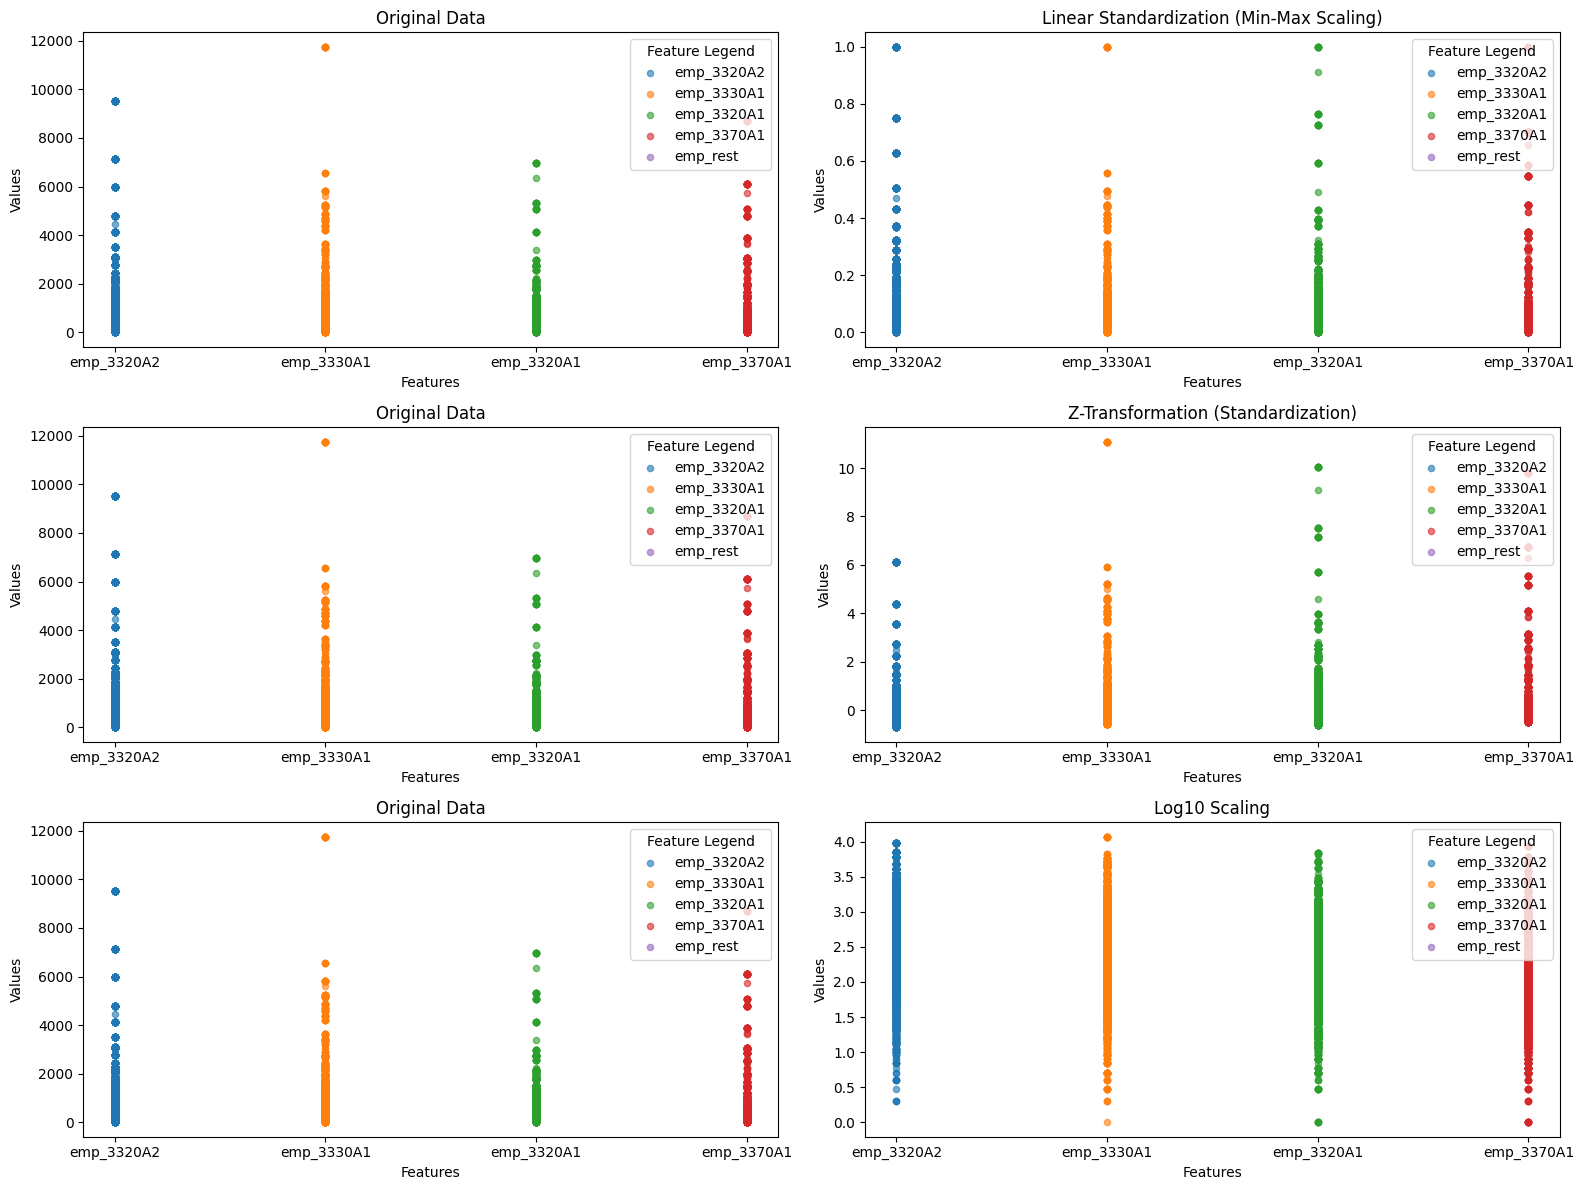

In [28]:
# Drop the 'FIPS' column
feature_df_pattern_no_fips = feature_df_pattern.drop(columns='FIPS')

# Linear Standardization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
feature_df_pattern_minmax = scaler_minmax.fit_transform(feature_df_pattern_no_fips)

# Z-transformation (Standardization)
scaler_standard = StandardScaler()
feature_df_pattern_zscore = scaler_standard.fit_transform(feature_df_pattern_no_fips)

# Log10 Scaling (with a small constant to avoid log(0))
feature_df_pattern_log10 = np.log10(feature_df_pattern_no_fips + 1e-9)

# Plotting function with automatic y-limits adjustment
def plot_features(data, title, ax):
    for i, col in enumerate(feature_df_pattern_no_fips.columns):
        non_nan_data = data[:, i][~np.isnan(data[:, i])]  # Get non-NaN data for each feature
        ax.scatter([col] * len(non_nan_data), non_nan_data, s=20, alpha=0.6, label=col)
    ax.set_xlabel("Features")
    ax.set_ylabel("Values")
    ax.set_title(title)
       

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharey=False)

# List of data pairs and titles for each subplot
data_pairs = [
    (feature_df_pattern_no_fips.to_numpy(), "Original Data", feature_df_pattern_minmax, "Linear Standardization (Min-Max Scaling)"),
    (feature_df_pattern_no_fips.to_numpy(), "Original Data", feature_df_pattern_zscore, "Z-Transformation (Standardization)"),
    (feature_df_pattern_no_fips.to_numpy(), "Original Data", feature_df_pattern_log10.to_numpy(), "Log10 Scaling")
]

# Plot each pair of datasets in the grid
for row, (original_data, original_title, transformed_data, transformed_title) in enumerate(data_pairs):
    # Plot original data in the left column
    plot_features(original_data, original_title, axes[row, 0])
    # Plot transformed data in the right column
    plot_features(transformed_data, transformed_title, axes[row, 1])

# Adjust layout and show legend for each subplot
for ax in axes.flat:
    if ax.has_data():
        ax.legend(title="Feature Legend", loc='upper right')
plt.tight_layout()
plt.show()


In [29]:
feature_df_pattern_log10

,emp_3320A2,emp_3330A1,emp_3320A1,emp_3370A1,emp_rest
0,2.086360,2.392697,1.857332,2.287802,NaN
1,1.977724,NaN,NaN,1.204120,NaN
2,2.513218,NaN,2.876218,1.518514,NaN
3,1.875061,NaN,NaN,0.778151,NaN
4,NaN,NaN,NaN,3.250420,NaN
...,...,...,...,...,...
1385,1.934498,NaN,2.296665,NaN,NaN
1386,1.707570,2.684845,1.623249,1.342423,NaN
1387,NaN,NaN,1.146128,NaN,NaN
1388,1.505150,NaN,NaN,NaN,NaN


d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
d:\TH-Koeln\WS24-25\DDM-WS24-25_Group\Repo-Gruppe-1\.venv\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

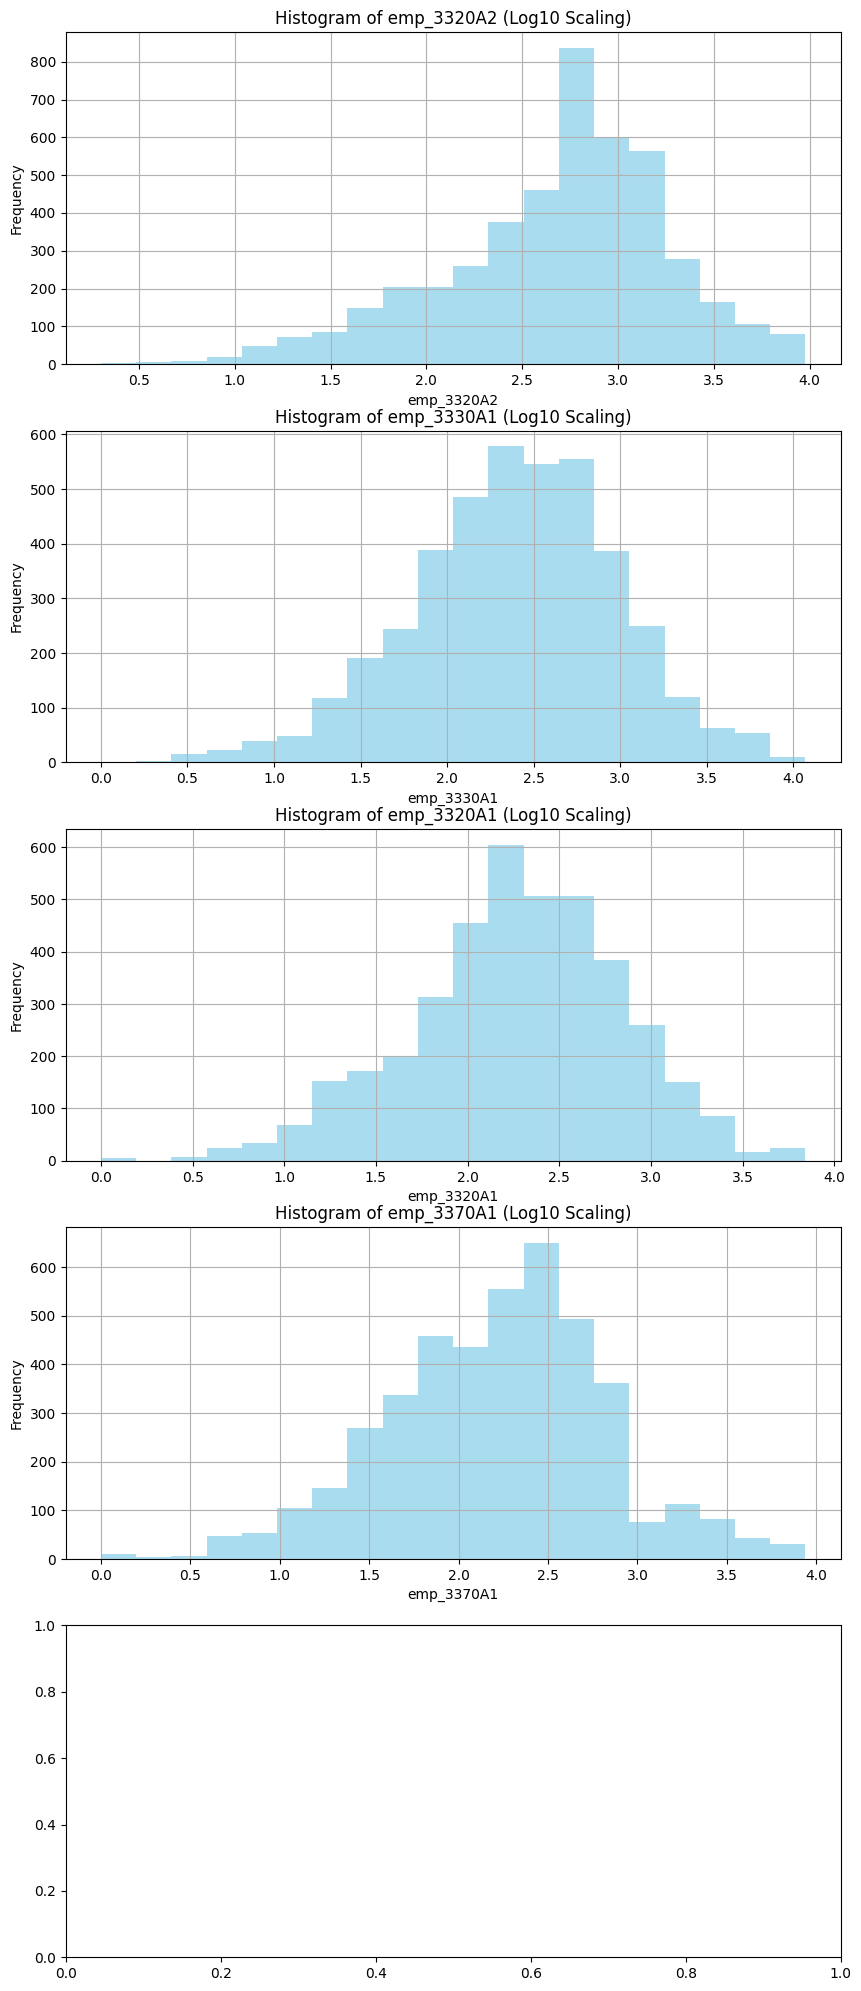

In [30]:
# Drop the 'FIPS' column
feature_df_pattern_no_fips = feature_df_pattern.drop(columns='FIPS')

# Log10 Scaling (with a small constant to avoid log(0))
feature_df_pattern_log10 = np.log10(feature_df_pattern_no_fips + 1e-9)

# Plotting function for histograms (only for log10 scaling)
def plot_histograms_log10(data):
    n_features = data.shape[1]
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5 * n_features))

    # Loop through each feature and plot its histogram
    for i, col in enumerate(feature_df_pattern_no_fips.columns):
        axes[i].hist(data[:, i], bins=20, alpha=0.7, color='skyblue')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Histogram of {col} (Log10 Scaling)')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Plot histograms for Log10 scaling
plot_histograms_log10(feature_df_pattern_log10.to_numpy())


# Dimension reduction

## PCA

### Sklearn PCA

In [ ]:
# Replace NaN values with 0
feature_df_filled = feature_df_pattern_log10.fillna(0)

# Initialize PCA and fit it to the filled DataFrame
n_components = 2  # Number of principal components, adjust as needed
pca_sk = PCA(n_components=2)
principal_components = pca_sk.fit_transform(feature_df_filled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(int(pca_sk.n_components_))])
display(pca_df)

# Optional: Print the explained variance ratio of each component
print("Explained variance ratio:", pca_sk.explained_variance_ratio_)

In [ ]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of First Two Principal Components')
plt.grid(True)
plt.show()

### Alternative PCA

In [ ]:
###########################################################
# COMPUTE AND VISUALIZE PCA
###########################################################
# Initialize the PCA, either reduce the data to the number of
# principal components that explain 95% of the total variance...
model = pca(n_components=0.95)
# ... or explicitly specify the number of PCs
#model = pca(n_components=2)

# Fit and transform
results = model.fit_transform(X=feature_df_filled)

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot(n_feat=4)

## SVD

In [ ]:
# Replace NaN values with 0
feature_df_filled = feature_df_pattern_log10.fillna(0)

# Initialize SVD and fit it to the DataFrame
n_components = 2  # Number of desired components
svd = TruncatedSVD(n_components=n_components)
svd_components = svd.fit_transform(feature_df_filled)

# Create a DataFrame with the SVD results
svd_df = pd.DataFrame(data=svd_components, columns=['Component 1', 'Component 2'])

# Scatter plot of the first two SVD components
plt.figure(figsize=(8, 6))
plt.scatter(svd_df['Component 1'], svd_df['Component 2'], alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD Scatter Plot of First Two Components')
plt.grid(True)
plt.show()

# Plotting

In [35]:
# Load the state shapefile data from a pickle file
state_shape = pd.read_pickle('../../data/raw/state.pickle')

# Load the county shapefile data from a pickle file
county_shape = pd.read_pickle('../../data/raw/county.pickle')

# Filtering the state shapes to exclude specific regions (Alaska, Hawaii, and U.S. territories) and storing the corresponding STATEFP codes.
filtered_statefp = state_shape.loc[~state_shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico', 'Commonwealth of the Northern Mariana Islands', 'American Samoa', 'United States Virgin Islands', 'Guam']), 'STATEFP']

# Creating a new DataFrame for state & county shapes that match the filtered STATEFP codes.
filtered_state_shape = state_shape[state_shape['STATEFP'].isin(filtered_statefp)]
filtered_county_shape = county_shape[county_shape['STATEFP'].isin(filtered_statefp)]
filtered_county_shape = filtered_county_shape.rename(columns={'GEOID': 'FIPS'})
filtered_county_shape = filtered_county_shape[['FIPS', 'geometry']]
filtered_state_shape = filtered_state_shape['geometry']

In [36]:
filtered_state_shape.to_pickle('../../data/processed/plot_state_shape.pickle')
filtered_county_shape.to_pickle('../../data/processed/plot_county_shape.pickle')

In [37]:
filtered_county_shape_merged = filtered_county_shape.merge(feature_df_pattern.fillna(0), on='FIPS', how='left')
filtered_county_shape_merged

,FIPS,geometry,emp_3320A2,emp_3330A1,emp_3320A1,emp_3370A1,emp_rest
0,21007,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",NaN,NaN,NaN,NaN,NaN
1,21017,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",NaN,NaN,NaN,NaN,NaN
2,21031,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",NaN,NaN,NaN,NaN,NaN
3,21065,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",NaN,NaN,NaN,NaN,NaN
4,21069,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
6586,26139,"POLYGON ((-86.26432 43.1183, -86.25103 43.1182...",498.0,2008.0,2054.0,5083.0,0.0
6587,26139,"POLYGON ((-86.26432 43.1183, -86.25103 43.1182...",498.0,2008.0,78.0,418.0,0.0
6588,26139,"POLYGON ((-86.26432 43.1183, -86.25103 43.1182...",498.0,2008.0,78.0,5083.0,0.0
6589,26139,"POLYGON ((-86.26432 43.1183, -86.25103 43.1182...",498.0,2008.0,563.0,418.0,0.0


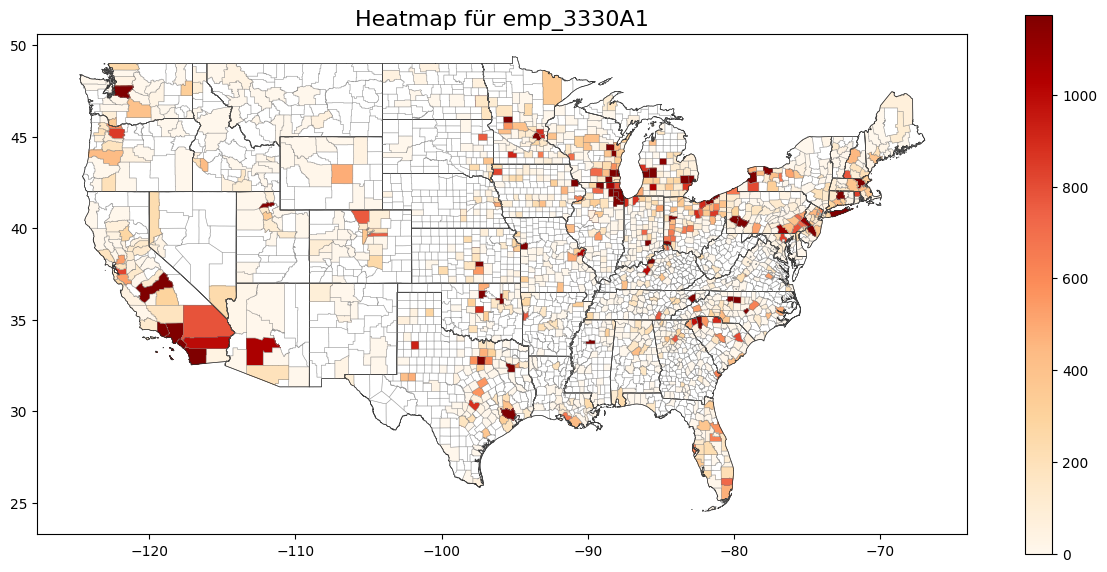

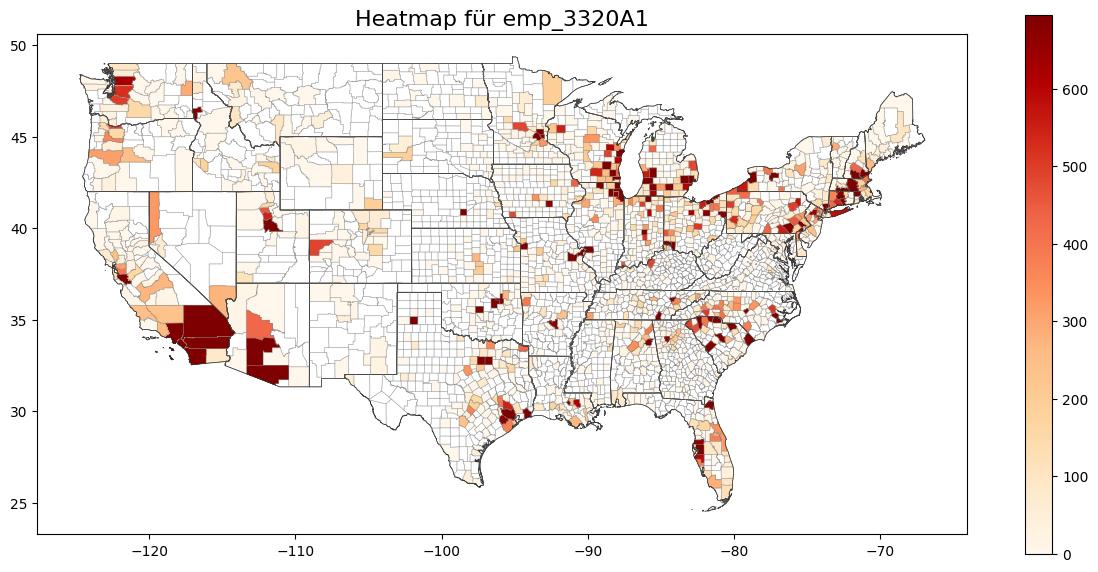

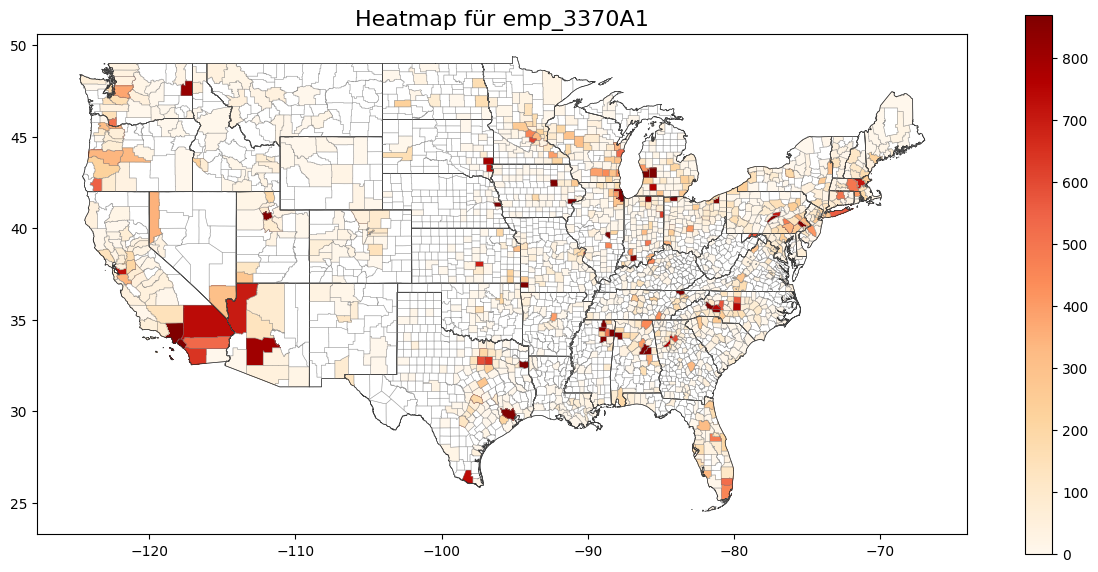

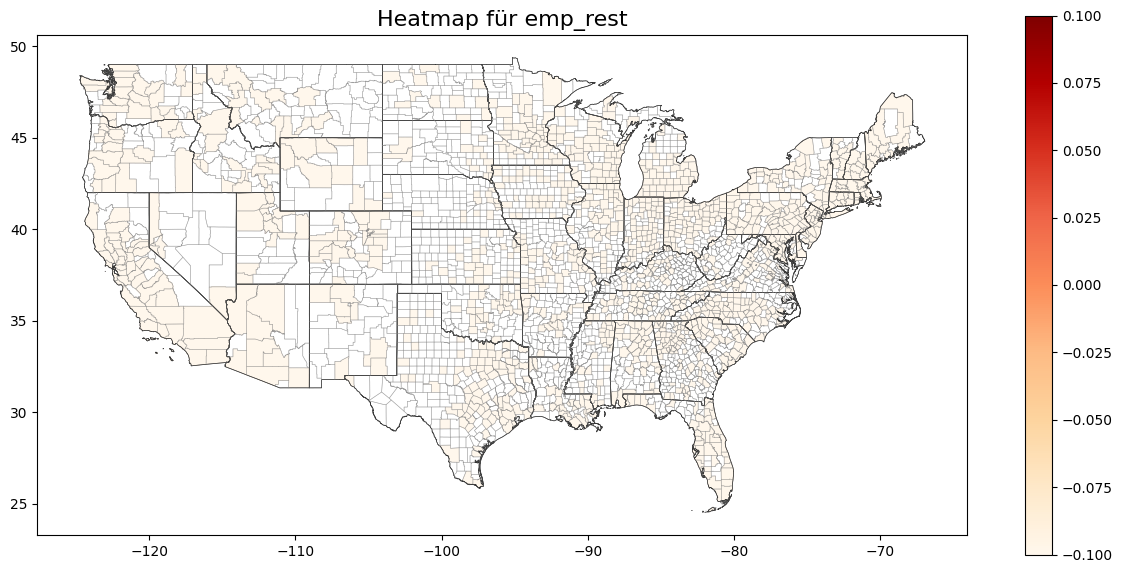

In [38]:
for column in filtered_county_shape_merged.columns[3:]:
    fig, ax = plt.subplots(figsize=(15, 7))

    # Defining the normalization range for the colormap.
    vmin = filtered_county_shape_merged[column].min() * 2  # Minimum value, adjusted for better color scaling.
    vmax = filtered_county_shape_merged[column].max() * 0.1  # Maximum value, adjusted for better color scaling.

    # Creating a heatmap for the current filter string.
    filtered_county_shape_merged.plot(
        column=column,  # The column used to determine the colors in the heatmap.
        cmap='OrRd',  # Color map selection (e.g., Orange-Red).
        linewidth=0.8,
        ax=ax,
        legend=True,  # Displaying the legend.
        vmin=vmin,  # Setting the minimum value for the colormap.
        vmax=vmax   # Setting the maximum value for the colormap.
    )

    # Adding outlines for the filtered states and counties.
    filtered_state_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    filtered_county_shape.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4, alpha=0.5)

    # Adding a title to the plot.
    ax.set_title(f'Heatmap für {column}', fontsize=16)

    # Displaying the plot.
    plt.show()